In [1]:
import os
import numpy as np
import pandas as pd
from compute_tempo import *
import matplotlib.pyplot as plt
from mutils import DataHandler

Loaded BKO_E1_D1_08_Suku_T.pkl
Error encountered for: Group 'gr' not found in the dataset.
Loaded BKO_E3_D5_03_Wasulunka_T.pkl
Total Sections: 1


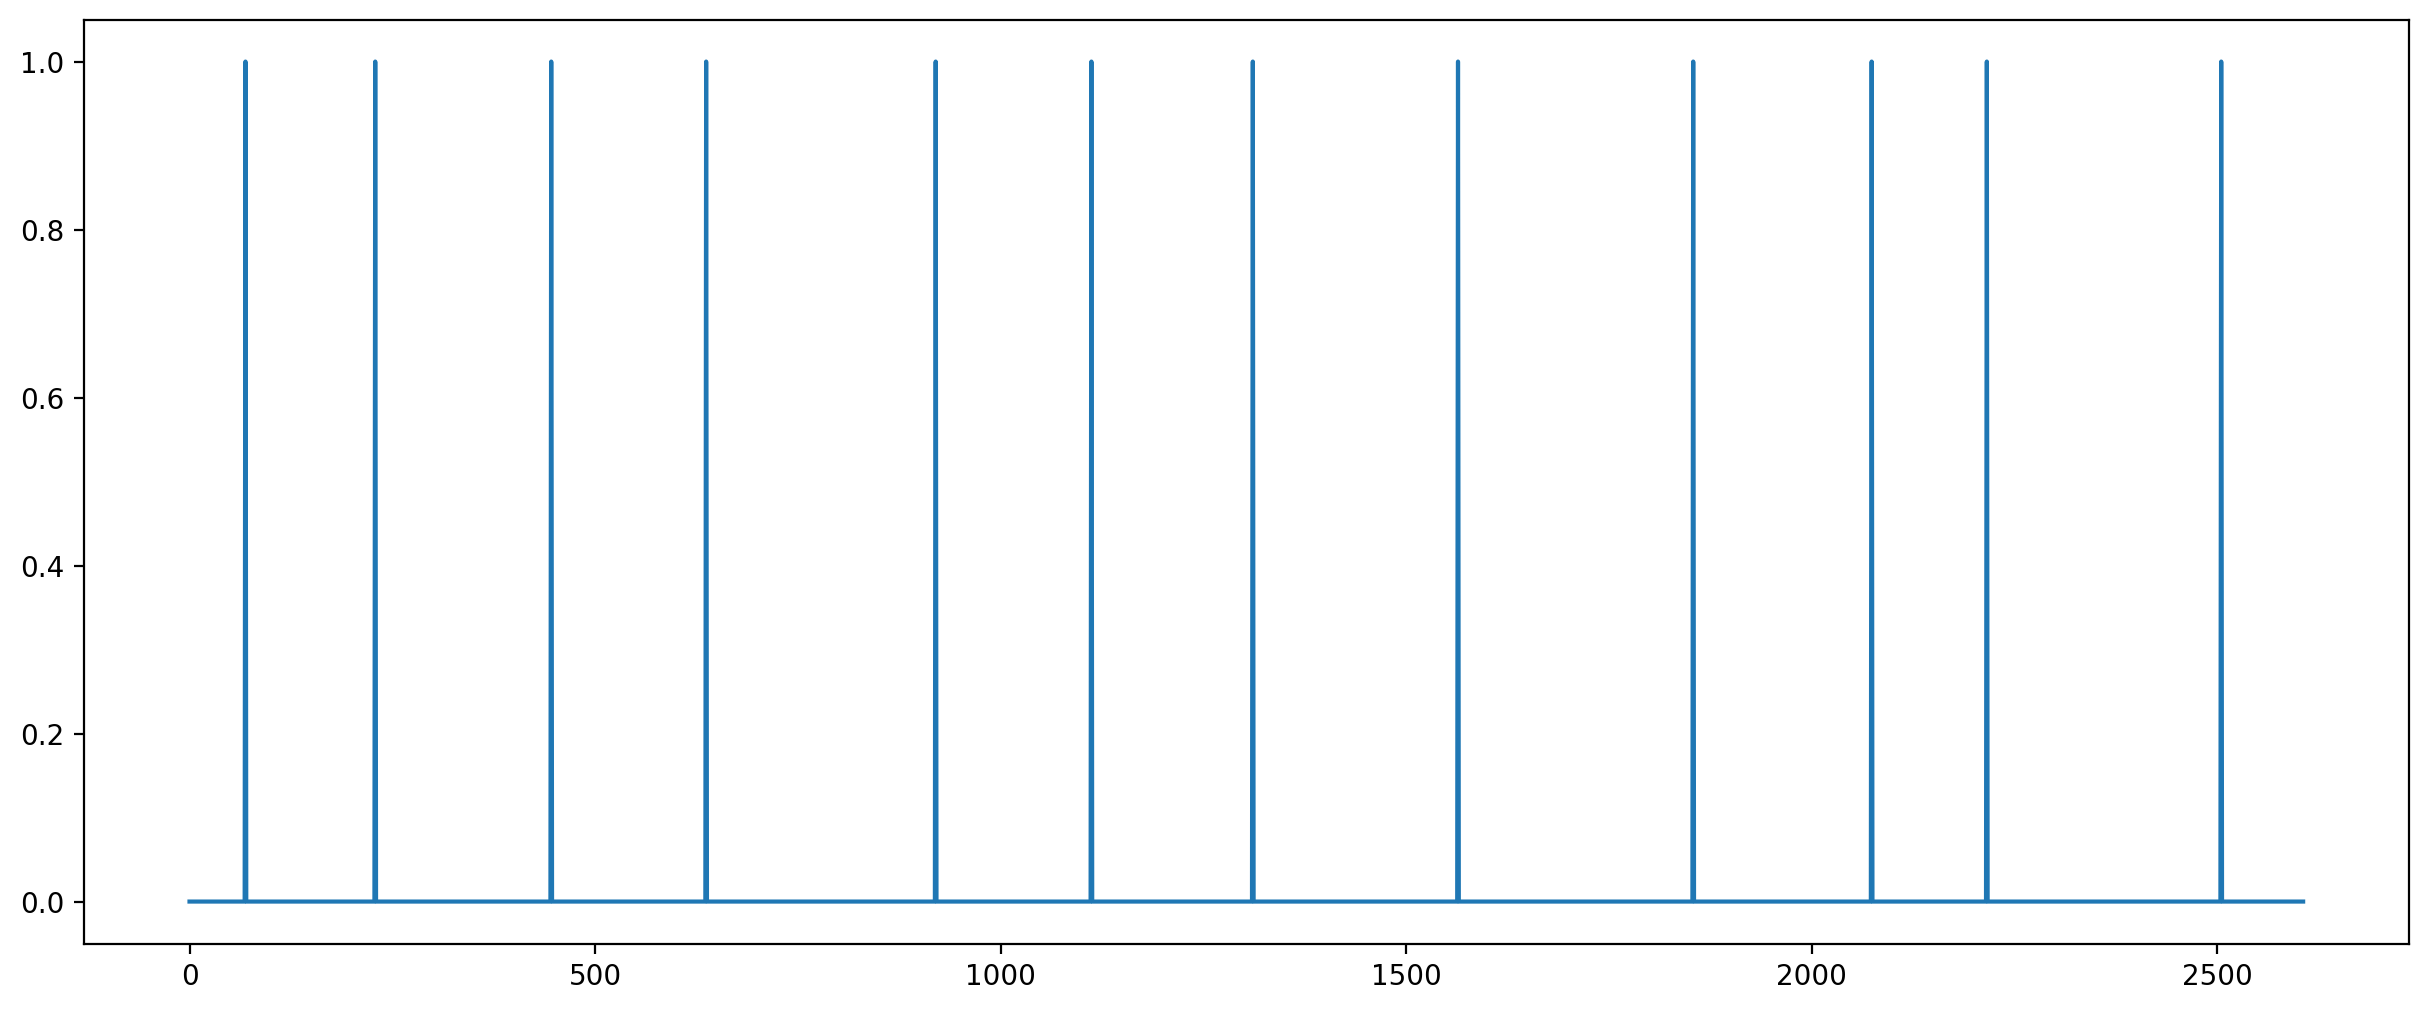

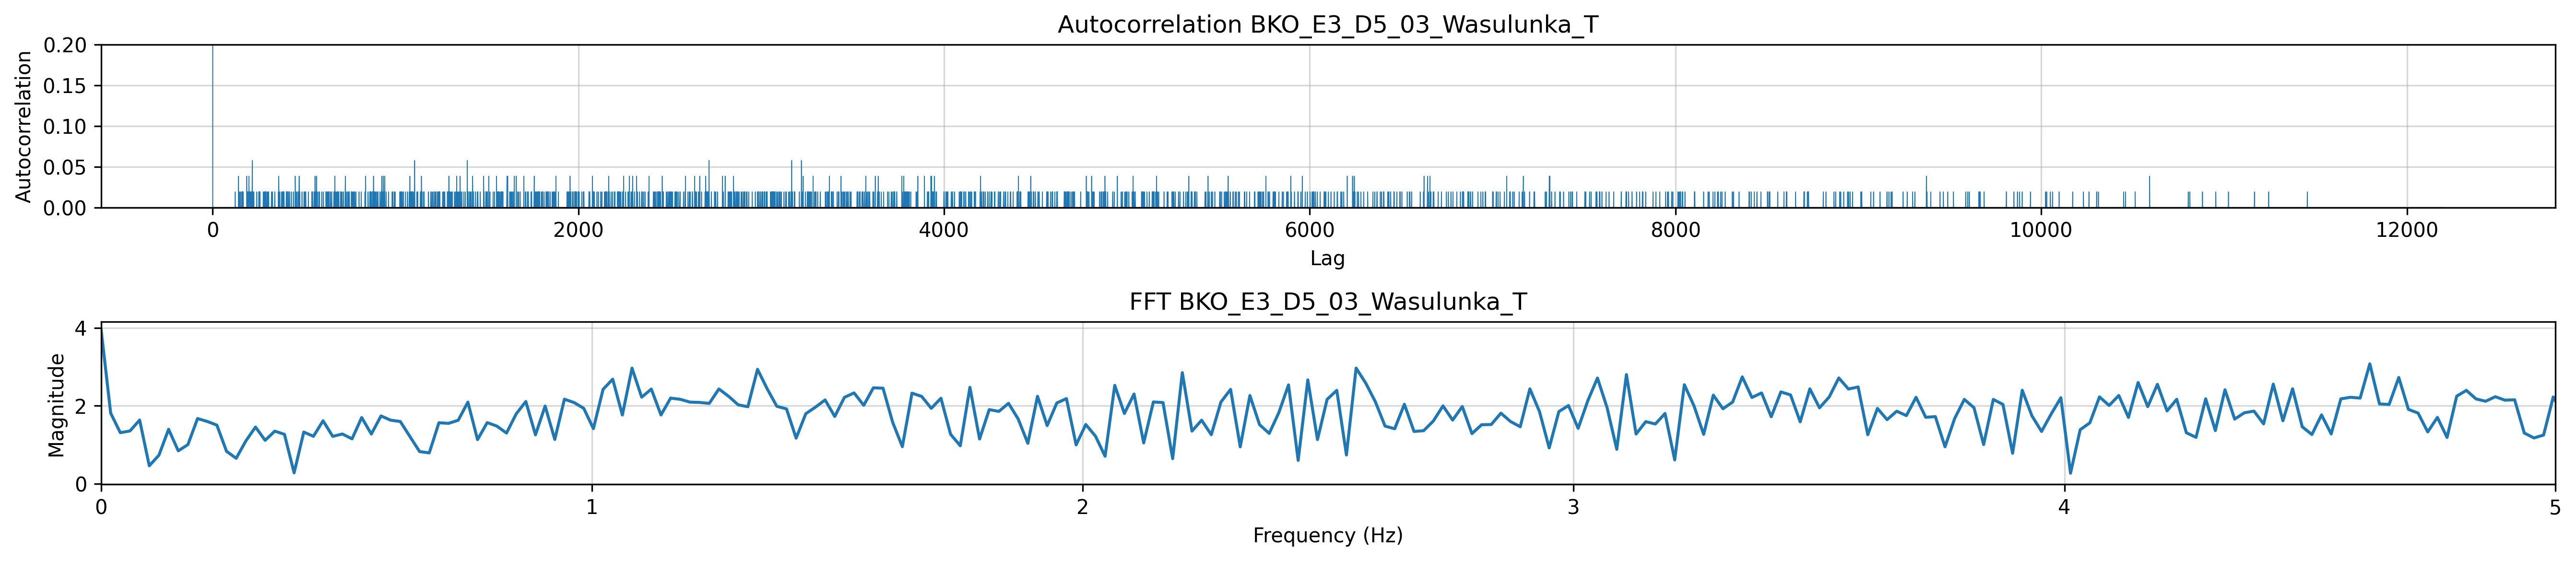

In [3]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT
pkl_filelist = os.listdir(f"/itf-fi-ml/home/sagardu/djembe_drive/sgr_pyspace/Dataset_V2")
data_handler = DataHandler()

for i, filename in enumerate(pkl_filelist):

    filename = filename.replace("_Dancers.csv", "_T.mvnx")
    piece_name = os.path.basename(filename).split(".")[0]
    try:
        motion_data, drum_onsets, start_f, end_f, start_t, end_t, cycle_onsets, beat_ref, bpm = data_handler.load_and_process_data(filename, mode = 'gr', drum = 'J2', section_idx=0)
    except ValueError as e:
        # Handle the error and continue
        print(f"Error encountered for: {e}")
        continue


    duration = int(end_t-start_t)
    w_sec = int(duration/2)
    h_sec = int(w_sec/2)
    
    mocap_fps = 240
    window_size = int(240*w_sec)
    hop_size = int(240*h_sec)
    tempi_range = np.arange(50,150,1)

    sensorA_velocity = motion_data['velocity']["SEGMENT_LEFT_FOOT"]         # [start_f:end_f]
    sensorA_position = motion_data['position']["SEGMENT_LEFT_FOOT"]         # [start_f:end_f]
    
    sensorA_velocity_norm = z_score_normalize(sensorA_velocity)
    sensorA_position_norm = z_score_normalize(sensorA_position)
    
    sensor_pos_axes = smooth_velocity(sensorA_position_norm, abs='no')                     # size (n, 3)
    sensorA_positiond= detrend_signal_array(sensor_pos_axes, cutoff= 0.8)
    
    zero_uni_onsets, zero_bi_onsets = get_zero_onsets(sensorA_velocity_norm, sensorA_positiond, 
                                                  distance_threshold=0.025,tcut= 0.5, vel_thres = 0.05,)
    ax=2
    sensorA_vel = zero_uni_onsets[start_f:end_f, ax]
    plt.figure(figsize=(15, 6), dpi=200)
    plt.plot(sensorA_vel[start_f:end_f])
    plt.show()
    
    # autocorrelation 1
    autocorr1 = np.correlate(sensorA_vel, sensorA_vel, mode='full')  
    mid_point1 = len(sensorA_vel) - 1 
    autocorr1 = autocorr1[mid_point1:]  
    autocorr1 = autocorr1 / autocorr1[0]  # Normalize


    autocorr = autocorr1

    # FFT
    fft_result = np.fft.fft(sensorA_vel)
    fft_magnitude = np.abs(fft_result)  
    frequencies = np.fft.fftfreq(len(sensorA_vel), d=1/mocap_fps)
        
    positive_freqs = frequencies[frequencies >= 0]
    positive_magnitude = fft_magnitude[frequencies >= 0]
    positive_magnitude_log = np.log1p(positive_magnitude)
    
    # Positive lags for x axis
    lags_x_axis = np.arange(0, len(sensorA_vel))

    
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 4), dpi=300)

    # Plot autocorrelation
    axes[0].plot(lags_x_axis, autocorr, linewidth= 0.4)
    axes[0].set_title(f'Autocorrelation {piece_name}')
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].grid(alpha=0.5)
    axes[0].set_ylim(0, 0.2)

    # Plot FFT
    axes[1].plot(positive_freqs , positive_magnitude_log)
    axes[1].set_title(f'FFT {piece_name}')
    axes[1].set_xlabel('Frequency (Hz)')
    axes[1].set_ylabel('Magnitude')
    axes[1].grid(alpha=0.5)
    axes[1].set_xlim(0, 5)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    
    if i == 1:
        break